# K Nearest Neighbors

In [4]:
# importing relevant packages and functions
%run /Users/thomasadler/Desktop/futuristic-platipus/notebooks/ta_00_packages_functions.py

In [5]:
# defining working directory
data_filepath = '/Users/thomasadler/Desktop/futuristic-platipus/data/'
model_filepath = '/Users/thomasadler/Desktop/futuristic-platipus/models/'
dictionary_filepath='/Users/thomasadler/Desktop/futuristic-platipus/data_dictionary/'
images_filepath = '/Users/thomasadler/Desktop/futuristic-platipus/images/'

# Preparing data

In [6]:
#clean dataset
modelling_df=pd.read_csv(data_filepath + 'master_modelling_df.csv', index_col=0)

#check
modelling_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107184 entries, 0 to 107183
Data columns (total 33 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   lat_deg                   107184 non-null  float64
 1   lon_deg                   107184 non-null  float64
 2   is_functioning            107184 non-null  int64  
 3   distance_to_primary       107184 non-null  float64
 4   distance_to_secondary     107184 non-null  float64
 5   distance_to_tertiary      107184 non-null  float64
 6   distance_to_city          107184 non-null  float64
 7   distance_to_town          107184 non-null  float64
 8   usage_cap                 107184 non-null  float64
 9   staleness_score           107184 non-null  float64
 10  is_complex_tech           107184 non-null  int64  
 11  is_installed_after_2006   107184 non-null  int64  
 12  is_public_management      107184 non-null  int64  
 13  crucialness               107184 non-null  f

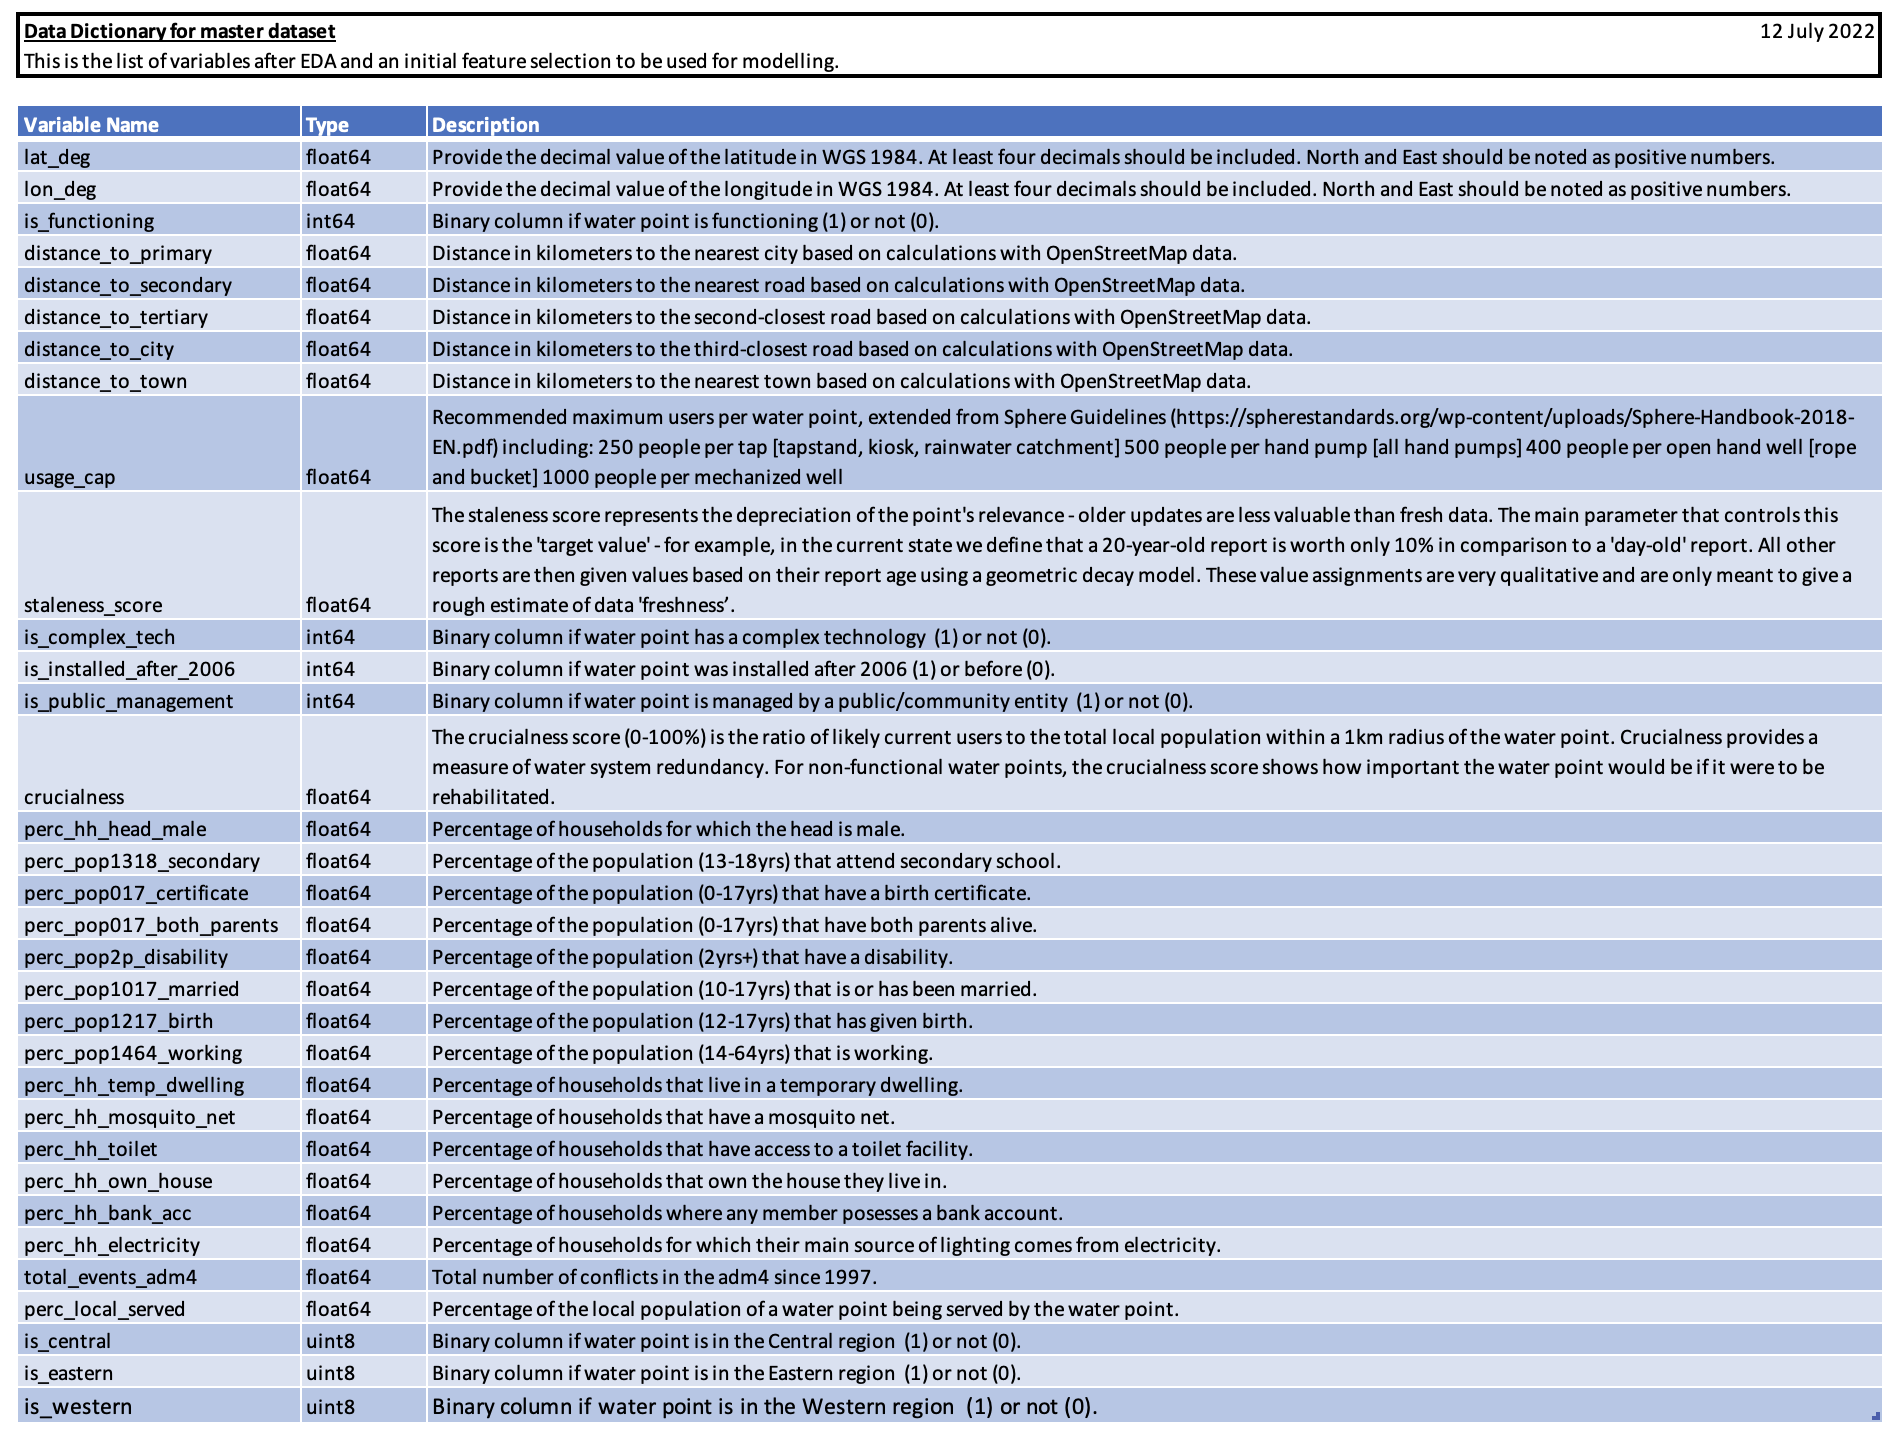

In [7]:
#data dictionary
Image(dictionary_filepath+"5-Modelling-Data-Dictionary.png")

In [8]:
#set random seed for consistent results
rand_seed=1

In [9]:
# assigning X (independent) and y (dependent) variables
X =modelling_df.loc[:, modelling_df.columns != 'is_functioning']
y = modelling_df['is_functioning']

#check
print(X.shape)
print(y.shape)

(107184, 32)
(107184,)


Our independent variable (X) should have the same number of rows (107,184) than our dependent variable (y). y should only have one column as it is the outcome variable.

In [10]:
#split train test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_seed)

In [11]:
# #resampling dataset
sm = SMOTE(random_state=rand_seed)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

#compre resampled dataset
print(f"Test set has {round(y_test.value_counts(normalize=True)[0]*100,1)}% non-functioning water points and {round(y_test.value_counts(normalize=True)[1]*100,1)}% functioning")
print(f"Original train set has {round(y_train.value_counts(normalize=True)[0]*100,1)}% non-functioning water points and {round(y_train.value_counts(normalize=True)[1]*100,1)}% functioning")
print(f"Resampled train set has {round(y_train_res.value_counts(normalize=True)[0]*100,1)}% non-functioning water points and {round(y_train_res.value_counts(normalize=True)[1]*100,1)}% functioning")

Test set has 19.7% non-functioning water points and 80.3% functioning
Original train set has 19.5% non-functioning water points and 80.5% functioning
Resampled train set has 50.0% non-functioning water points and 50.0% functioning


We over-sample the minority class, non-functioning water points, to get an equal distribution of our outcome variable. Note this should be done on the train set and not the test set as we should not tinker with the latter.

In [12]:
# scale the data
X_train_res_scaled, X_test_scaled = scaling(StandardScaler(), X_train_res, X_test)

# Running baseline model

In [21]:
#time process
start=time.time()

#instantiate and fit
KNN_base = KNeighborsClassifier().fit(X_train_res, y_train_res)

end=time.time()

time_fit_base=end-start

print(f"Time to fit the model on the training set is {round(time_fit_base,3)} seconds")

Time to fit the model on the training set is 0.105 seconds


ROC AUC: 0.9701145378177232
PR AUC: 0.9719271547483631
              precision    recall  f1-score   support

           0       0.86      0.94      0.90     68984
           1       0.93      0.85      0.89     68984

    accuracy                           0.89    137968
   macro avg       0.90      0.89      0.89    137968
weighted avg       0.90      0.89      0.89    137968



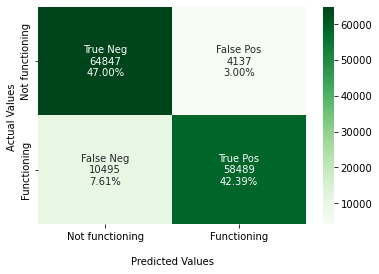

In [59]:
# get classification report for train 
fpr_train_base, tpr_train_base, roc_auc_train_base, precision_train_base_plot, recall_train_base_plot, pr_auc_train_base, time_predict_train_base = print_report(KNN_base, X_train_res_scaled, y_train_res)

#storing accuracy scores
accuracy_train_base, precision_train_base, recall_train_base, f1_train_base = get_scores(KNN_base, X_train_res_scaled, y_train_res)


Our first KNN  has a relatively very accuracy score of 89% on the training set. However, this is only because our model is currently labelling nearly all water points as functioning. Errors mostly come from not recognising functioning water points, shown by the low recall score of 85% for functioning water points.

ROC AUC: 0.7714408297950855
PR AUC: 0.9318963293586018
              precision    recall  f1-score   support

           0       0.42      0.64      0.51      4221
           1       0.90      0.78      0.84     17216

    accuracy                           0.76     21437
   macro avg       0.66      0.71      0.67     21437
weighted avg       0.80      0.76      0.77     21437



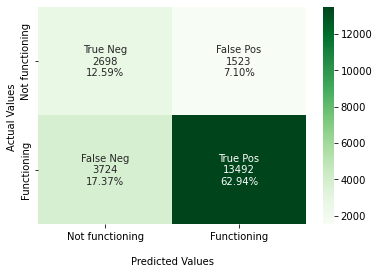

Time to predict the outcome variable for the test set is 3.65 seconds


In [61]:
# get classification report and confusion matrix for test
fpr_test_base, tpr_test_base, roc_auc_test_base, precision_test_base_plot, recall_test_base_plot, pr_auc_test_base, time_predict_test_base = print_report(KNN_base, X_test_scaled, y_test)

print(f"Time to predict the outcome variable for the test set is {round(time_predict_test_base,3)} seconds")

#storing accuracy scores
accuracy_test_base, precision_test_base, recall_test_base, f1_test_base = get_scores(KNN_base, X_test_scaled, y_test)

Our test set has an accuracy score of 76%. Similarly to the training set, it misses quite a lot of functioning water points (mislabels around a fifth of all functioning points) and also non-functioning points (around a third of all non-functioning points).

# Narrowing down parameters

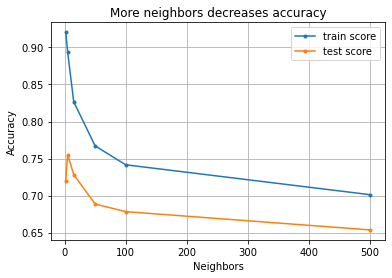

In [13]:
# look at the accuracy of the test score depending on the number of neighbors

# set range of neighbors
k_range = [2, 5, 15, 50, 100, 500]
accuracy_scores = pd.DataFrame()

for k in k_range:

    #instantiate and fit
    KNN = KNeighborsClassifier(n_neighbors=k).fit(
        X_train_res_scaled, y_train_res)

    # store accuracy scores
    train_score = KNN.score(X_train_res_scaled, y_train_res)
    test_score = KNN.score(X_test_scaled, y_test)

    # append to list
    accuracy_scores = accuracy_scores.append(
        {'Neighbors': k, 'Train_score': train_score, 'Test_score': test_score}, ignore_index=True)

# visualise relationship between neighbors and accuracy
plt.figure()

plt.plot(accuracy_scores['Neighbors'],
         accuracy_scores['Train_score'], label='train score', marker='.')
plt.plot(accuracy_scores['Neighbors'],
         accuracy_scores['Test_score'], label='test score', marker='.')

plt.xlabel('Neighbors')
plt.ylabel("Accuracy")

plt.title("More neighbors decreases accuracy")
plt.legend(loc='best')
plt.grid()

plt.show()

As the number of neighbors we take into account increases, the accuracy of our model decreases. We need a good middle ground where the gap between the train and test set is not too high (opposite of that is when k=2) and the test accuracy scores are still relatively high (opposite is when k=500). It seems that this middle ground is when k is lower than 100 neighbors

# Finding optimal hyperparameters

We run a randomised cross validation through a pipeline to find the optimal hyperparameters. We choose a randomised as opposed to a grid search because KNN models are very expensive.

In [31]:
# setting up which models/scalers we want to grid search
estimator = [('scaling', StandardScaler()),
 ('reduce_dim', PCA()),
             ('KNN', KNeighborsClassifier())]

# defining distribution of parameters we want to compare
param_dist = [{"KNN__n_neighbors": range(1, 50, 1),
'reduce_dim__n_components': np.arange(0.5, 0.9, 0.1)},

{"KNN__n_neighbors": range(1, 50, 1),
'reduce_dim': [None]}]

# run cross validation
pipeline_cross_val_random(estimator, param_dist, X_train_res_scaled, y_train_res, X_test_scaled, y_test)

The model with the best CV score has the following parameters: {'reduce_dim__n_components': 0.7, 'KNN__n_neighbors': 5}.
The best model has an accuracy score of 0.751131221719457 on the test set


The best model here seems to have a very similar accuracy score, but hopefully it scores better on its precision and recall scores. It seems that the optimal number of neighbors is 5. This is the same deafult number of k neighbors that the model had taken in our baseline model. The optimal model also chooses to reduce dimensions (using PCA) to the minimum number of features which can explain 70% of the variance in the dataset.

# Running optimised model

In [26]:
#PCA transformation basedon randomised search
X_train_res_scaled_PCA, X_test_scaled_PCA=run_PCA(0.7, X_train_res_scaled, X_test_scaled)

train shape: (137968, 10)
test shape: (21437, 10)


Note that the PCA transformer should be fitted on the training set and then should be used to transform the training and test set. We end up with 10 features that explain 70% of the variance in our dataset.

In [27]:
#time process
start=time.time()

#instantiate and fit
KNN_opt = KNeighborsClassifier(n_neighbors=5).fit(X_train_res_scaled_PCA, y_train_res)

end=time.time()

time_fit_opt=end-start

print(f"Time to fit the model on the training set is {round(time_fit_opt, 3)} seconds")

Time to fit the model on the training set is 0.206 seconds


The time to fit the model with our optimal parameter is 10x longer than in the baseline model.

ROC AUC: 0.9666709344582073
PR AUC: 0.968951318578696
              precision    recall  f1-score   support

           0       0.86      0.93      0.89     68984
           1       0.93      0.84      0.88     68984

    accuracy                           0.89    137968
   macro avg       0.89      0.89      0.89    137968
weighted avg       0.89      0.89      0.89    137968



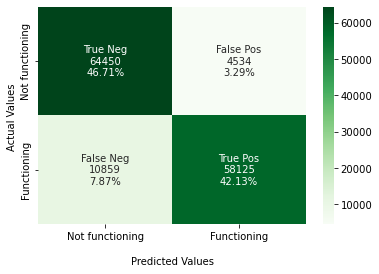

In [38]:
# get classification report for train
fpr_train_opt, tpr_train_opt, roc_auc_train_opt, precision_train_opt_plot, recall_train_opt_plot, pr_auc_train_opt, time_predict_train_opt = print_report(KNN_opt, X_train_res_scaled_PCA, y_train_res)

#storing accuracy scores
accuracy_train_opt, precision_train_opt, recall_train_opt, f1_train_opt = get_scores(KNN_opt, X_train_res_scaled_PCA, y_train_res)

The various accuracy metrics for the training set have all stayed the same compared to the baseline model. There has been close to no improvements made by PCA transforming our data.

ROC AUC: 0.7720583030369483
PR AUC: 0.9323638273385908
              precision    recall  f1-score   support

           0       0.41      0.64      0.50      4221
           1       0.90      0.78      0.83     17216

    accuracy                           0.75     21437
   macro avg       0.66      0.71      0.67     21437
weighted avg       0.80      0.75      0.77     21437



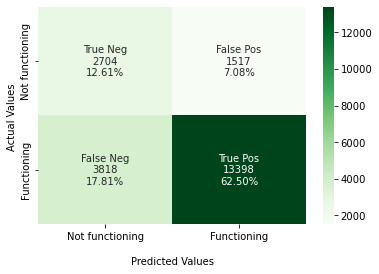

Time to predict the outcome variable for the test set is 1.847 seconds


In [39]:
# get classification report for test
fpr_test_opt, tpr_test_opt, roc_auc_test_opt, precision_test_opt_plot, recall_test_opt_plot, pr_auc_test_opt, time_predict_test_opt = print_report(KNN_opt, X_test_scaled_PCA, y_test)

print(f"Time to predict the outcome variable for the test set is {round(time_predict_test_opt,3)} seconds")

#storing accuracy scores
accuracy_test_opt, precision_test_opt, recall_test_opt, f1_test_opt = get_scores(KNN_opt, X_test_scaled_PCA, y_test)

On the whole, the optimised model actually performs slightly worse than the baseline model. We infer this from the accuracy score which is lower by 2 percentage points. All other metrics are the same. The fact that we did not need to apply any hyperparameter optimisation nor any dimensionality reduction using PCA makes the baseline model quite attractive. A small caveat is that the optimised model took much less time to predict the outcome variable for the test set (<2sec vs >4sec).

# Comparing results

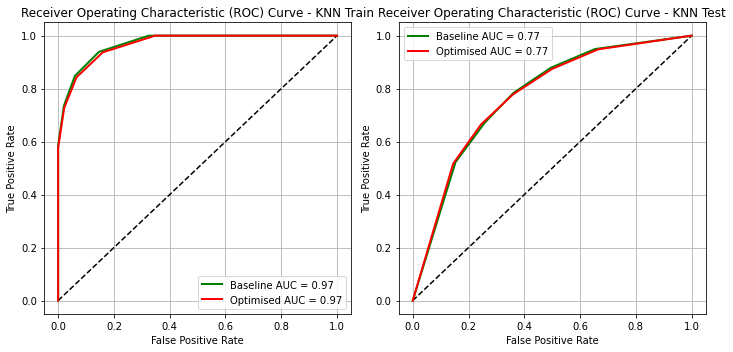

In [40]:
#compare ROCs on train and test

plt.subplots(1,2, figsize=(10,5))
plt.subplot(1,2,1)
plt.plot([0,1], [0,1], color='black', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve - KNN Train')
plt.plot(fpr_train_base, tpr_train_base, color='green', lw=2,
    label='Baseline AUC = %0.2f' % roc_auc_train_base)
plt.plot(fpr_train_opt, tpr_train_opt, color='red', lw=2,
    label='Optimised AUC = %0.2f' % roc_auc_train_opt)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="best")
plt.tight_layout()
plt.grid()

plt.subplot(1,2,2)
plt.plot([0,1], [0,1], color='black', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve - KNN Test')
plt.plot(fpr_test_base, tpr_test_base, color='green', lw=2,
    label='Baseline AUC = %0.2f' % roc_auc_test_base)
plt.plot(fpr_test_opt, tpr_test_opt, color='red', lw=2,
    label='Optimised AUC = %0.2f' % roc_auc_test_opt)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="best")
plt.tight_layout()
plt.grid()

plt.show()


The baseline and optimised models both have the same AUC for the train and test set. The shape of their respective curves are nearly identical. PCA reduction has not improved our model. Since PCA makes our results less interpretable and doesn't improve the model, we choose the baseline model to be our best one.

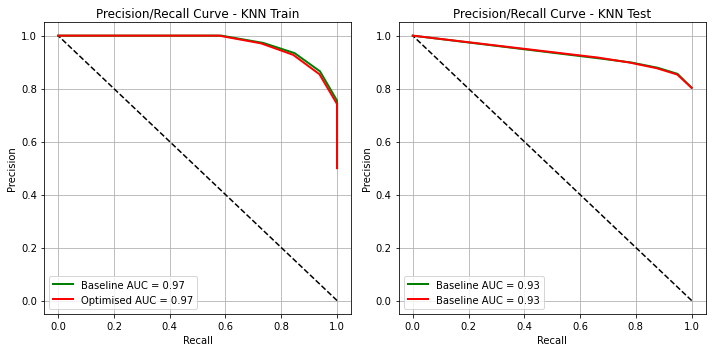

In [41]:
#compare Precision/Recall Curve on train and test

plt.subplots(1,2, figsize=(10,5))
plt.subplot(1,2,1)
plt.plot([1,0], [0,1], color='black', linestyle='--')
plt.title('Precision/Recall Curve - KNN Train')
plt.plot(recall_train_base_plot, precision_train_base_plot, color='green', lw=2,
    label='Baseline AUC = %0.2f' % pr_auc_train_base)
plt.plot(recall_train_opt_plot, precision_train_opt_plot, color='red', lw=2,
    label='Optimised AUC = %0.2f' % pr_auc_train_opt)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="best")
plt.tight_layout()
plt.grid()

plt.subplot(1,2,2)
plt.plot([1,0], [0,1], color='black', linestyle='--')
plt.title('Precision/Recall Curve - KNN Test')
plt.plot(recall_test_base_plot, precision_test_base_plot, color='green', lw=2,
    label='Baseline AUC = %0.2f' % pr_auc_test_base)
plt.plot(recall_test_opt_plot, precision_test_opt_plot, color='red', lw=2,
    label='Optimised AUC = %0.2f' % pr_auc_test_opt)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="best")
plt.tight_layout()
plt.grid()

plt.show()


# Exporting

In [42]:
#export model results
joblib.dump(KNN_base, model_filepath+'k_nearest_neighbors_model.sav')

['/Users/thomasadler/Desktop/futuristic-platipus/models/k_nearest_neighbors_model.sav']

In [43]:
#export best model in dataframe
d = {'Model':['K Nearest Neighbors'], 'Parameters':['Neighbors=5, PCA=0.7, Standard Scaler'], 'Accuracy Train': [accuracy_train_base],\
    'Precision Train': [precision_train_base], 'Recall Train': [recall_train_base], 'F1 Train': [f1_train_base], 'FPR Train Plot': [fpr_train_base],\
        'TPR Train Plot':[tpr_train_base], 'ROC AUC Train':[roc_auc_train_base], 'Precision Train Plot': [precision_train_base_plot],\
            'Recall Train Plot':[recall_train_base_plot], 'PR AUC Train':[pr_auc_train_base], 'Accuracy Test': accuracy_test_base,\
                'Precision Test': [precision_test_base], 'Recall Test': [recall_test_base], 'F1 Test': [f1_test_base], 'FPR Test Plot': [fpr_test_base],\
                    'TPR Test Plot':[tpr_test_base], 'ROC AUC Test':[roc_auc_test_base], 'Precision Test Plot': [precision_test_base_plot],\
                        'Recall Test Plot':[recall_test_base_plot], 'PR AUC Test':[pr_auc_test_base], 'Time Fit': time_fit_base, 'Time Predict': time_predict_test_base}

#to dataframe
best_model_result_df=pd.DataFrame(data=d)

#check
best_model_result_df

,Model,Parameters,Accuracy Train,Precision Train,Recall Train,F1 Train,FPR Train Plot,TPR Train Plot,ROC AUC Train,Precision Train Plot,...,Recall Test,F1 Test,FPR Test Plot,TPR Test Plot,ROC AUC Test,Precision Test Plot,Recall Test Plot,PR AUC Test,Time Fit,Time Predict
0,K Nearest Neighbors,"Neighbors=5, PCA=0.7, Standard Scaler",0.893946,0.897322,0.893946,0.893721,"[0.0, 0.0, 0.020830917314159807, 0.05997042792...","[0.0, 0.5855125826278558, 0.7356923344543662, ...",0.970115,"[0.5, 0.7546657914888962, 0.8652851817708125, ...",...,0.755236,0.772188,"[0.0, 0.1535181236673774, 0.2572850035536603, ...","[0.0, 0.5225952602230484, 0.6703647769516728, ...",0.771441,"[0.8030974483369875, 0.8557068062827226, 0.878...","[1.0, 0.9493494423791822, 0.8788917286245354, ...",0.931896,0.018093,4.142639


In [44]:
#export new dataset
best_model_result_df.to_csv(model_filepath + 'k_nearest_neighbors_model.csv')